In [5]:
!pip install torchmetrics -Uqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.1 MB/s eta 0:00:00


# Linear Regression

In [ ]:
# Import Libraries

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader,Dataset,TensorDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

### Data

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
X, y, expected_coef = make_regression(n_samples=1000,n_features=4,n_informative=4,bias=3.8,coef=True)

X = torch.tensor(X,device=device).view(-1,4).type(torch.float)
y = torch.tensor(y,device=device).view(-1,1).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([800, 4]),
 torch.Size([200, 4]),
 torch.Size([800, 1]),
 torch.Size([200, 1]))

### Model

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.linear_layer = nn.Linear(4,1,bias=True)

    def forward(self,x):
        return self.linear_layer(x)

torch.manual_seed(42)
model = LinearRegression().to(device)
model,model.state_dict()

(LinearRegression(
   (linear_layer): Linear(in_features=4, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[ 0.3823,  0.4150, -0.1171,  0.4593]], device='cuda:0')),
              ('linear_layer.bias', tensor([-0.1096], device='cuda:0'))]))

### Train and Test Loop

In [ ]:
# HYPERPARAMETERS

EPOCHS = 50
LEARNING_RATE = 0.1
LOG_INTERVAL = 5

In [ ]:
# Loss
loss_function = nn.MSELoss(reduction='mean')

# Optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=LEARNING_RATE)

In [ ]:
## Train & Test Loop

def train_test_loop(epochs,X_train, X_test, y_train, y_test,model,loss_function,optimizer,log_interval):

    for epoch in range(epochs):
        # Train
        model.train()
        y_pred = model(X_train)
        loss = loss_function(y_pred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Test
        model.eval()
        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = loss_function(test_pred,y_test)

        # Print
        if epoch % log_interval == 0:
            print(f"Epoch: {epoch} | Train Loss:{loss:.4f} | Test Loss:{test_loss:.4f}")


In [ ]:
train_test_loop(EPOCHS,X_train, X_test, y_train, y_test,model,loss_function,optimizer,LOG_INTERVAL)

Epoch: 0 | Train Loss:6068.2251 | Test Loss:3212.6758
Epoch: 5 | Train Loss:614.4936 | Test Loss:331.1610
Epoch: 10 | Train Loss:63.7636 | Test Loss:35.1202
Epoch: 15 | Train Loss:6.7884 | Test Loss:3.8334
Epoch: 20 | Train Loss:0.7416 | Test Loss:0.4302
Epoch: 25 | Train Loss:0.0831 | Test Loss:0.0495
Epoch: 30 | Train Loss:0.0095 | Test Loss:0.0058
Epoch: 35 | Train Loss:0.0011 | Test Loss:0.0007
Epoch: 40 | Train Loss:0.0001 | Test Loss:0.0001
Epoch: 45 | Train Loss:0.0000 | Test Loss:0.0000


In [ ]:
model.state_dict(),expected_coef

(OrderedDict([('linear_layer.weight',
               tensor([[74.3125,  7.5378, 19.7335,  1.3299]], device='cuda:0')),
              ('linear_layer.bias', tensor([3.7994], device='cuda:0'))]),
 array([74.31368925,  7.53737783, 19.73343069,  1.33034966]))

# Binary Classification

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader,Dataset,TensorDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [ ]:
from torchmetrics import Accuracy

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data

In [ ]:
X, y = make_circles(n_samples=1000,noise=0.1,random_state=42)

X = torch.tensor(X,device=device).view(-1,2).type(torch.float)
y = torch.tensor(y,device=device).view(-1,1).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 1]))

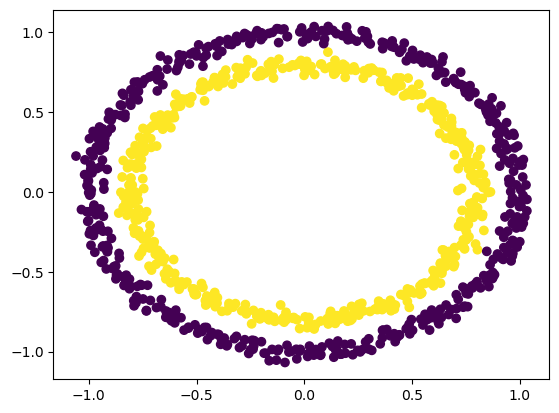

In [ ]:
X, y = make_circles(n_samples=1000,noise=0.03,random_state=42)
plt.scatter(X[:,0],X[:,1],c=y)

### Model

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(2,10),
            nn.ReLU(),
            nn.Linear(10,10),
            nn.ReLU(),
            nn.Linear(10,1),
        )

    def forward(self,x):
        return self.layers(x)

model = BinaryClassification().to(device)
model

BinaryClassification(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
EPOCHS = 10000
LEARNING_RATE = 1e-1
LOG_INTERVAL = 300

In [ ]:
# Loss
loss_function = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),LEARNING_RATE)

In [ ]:
torchmetrics_accuracy = Accuracy(
    task='binary',
    num_classes=2
).to(device)

### Train Test Loop

In [ ]:
def train_test_loop(epochs,X_train, X_test, y_train, y_test,model,optimizer,loss_function,log_interval):

    for epoch in range(epochs):
        # Train
        model.train()

        y_logits = model(X_train)

        loss = loss_function(y_logits,y_train)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # y_pred = torch.round(torch.sigmoid(y_logits))
        train_acc = torchmetrics_accuracy(y_logits,y_train)*100.0

        # Test
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            # test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_function(y_test,test_logits)
            test_acc = torchmetrics_accuracy(test_logits,y_test)*100.0

        # Print
        if epoch % log_interval == 0:
            print(
                f"""Epoch: {epoch}| Train Loss: {loss:.4f} | Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}""")

In [ ]:
train_test_loop(EPOCHS,X_train, X_test, y_train, y_test,model,optimizer,loss_function,LOG_INTERVAL)

Epoch: 0| Train Loss: 0.6944 | Train Accuracy: 50.00 | Test Loss: 1.0630 | Test Accuracy: 50.00
Epoch: 300| Train Loss: 0.6896 | Train Accuracy: 51.12 | Test Loss: 0.9998 | Test Accuracy: 55.00
Epoch: 600| Train Loss: 0.6856 | Train Accuracy: 55.75 | Test Loss: 0.9941 | Test Accuracy: 59.00
Epoch: 900| Train Loss: 0.6774 | Train Accuracy: 58.25 | Test Loss: 0.9836 | Test Accuracy: 60.00
Epoch: 1200| Train Loss: 0.6567 | Train Accuracy: 62.25 | Test Loss: 0.9601 | Test Accuracy: 62.00
Epoch: 1500| Train Loss: 0.5853 | Train Accuracy: 77.00 | Test Loss: 0.9054 | Test Accuracy: 65.00
Epoch: 1800| Train Loss: 0.4133 | Train Accuracy: 84.25 | Test Loss: 0.6569 | Test Accuracy: 73.00
Epoch: 2100| Train Loss: 0.3965 | Train Accuracy: 83.25 | Test Loss: 0.8042 | Test Accuracy: 70.50
Epoch: 2400| Train Loss: 0.3777 | Train Accuracy: 83.50 | Test Loss: 0.6928 | Test Accuracy: 73.50
Epoch: 2700| Train Loss: 0.3663 | Train Accuracy: 83.75 | Test Loss: 0.6140 | Test Accuracy: 75.50
Epoch: 3000| Tra

# Multi Class Classification

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Data

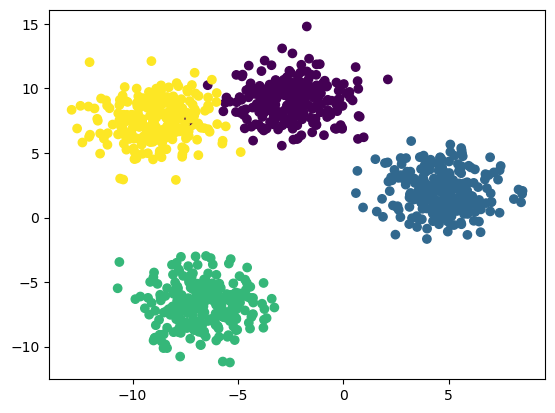

In [ ]:
X ,y = make_blobs(n_samples=1000,centers=4,n_features=2,random_state=42,cluster_std=1.5)

X.shape,y.shape
X[:5],y[:5]

plt.scatter(
    X[:,0],
    X[:,1],
    c = y
)

In [ ]:
X ,y = make_blobs(n_samples=1000,centers=4,n_features=2,random_state=42,cluster_std=1.5)

X = torch.tensor(X,device=device).view(-1,2).type(torch.float)
y = torch.tensor(y,device=device).long()
# X.shape,y.shape
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### Model

In [ ]:
class  MultiClassClassification(nn.Module):
    def __init__(self, input_dim,output_dim,hidden_dim) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )

    def forward(self,x):
        return self.layers(x)

model = MultiClassClassification(
    input_dim=2,
    hidden_dim=20,
    output_dim=4
).to(device)

model

MultiClassClassification(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=4, bias=True)
  )
)

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-2
LOG_INTERVAL = 1

In [ ]:
# Loss
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(),LEARNING_RATE)

# Metric
torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=4).to(device)

### Training Loop

In [ ]:


def train_test_loop(epochs,X_train, X_test, y_train, y_test,model,loss_function,optimizer,log_interval):

    for epoch in range(epochs+1):
        # Train
        model.train()

        y_train_op = model(X_train)
        loss = loss_function(y_train_op,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # y_train_probs = torch.softmax(y_train_op,dim=1)
        # y_train_preds = y_train_probs.argmax(dim=1)
        train_acc = torchmetrics_accuracy(y_train_op,y_train) * 100

        # Inference
        model.eval()
        with torch.inference_mode():
            y_test_op = model(X_test)
            test_loss = loss_function(y_test_op,y_test)
            # y_test_probs = torch.softmax(y_test_op,dim=1)
            # y_test_preds = y_test_probs.argmax(dim=1)
            test_acc = torchmetrics_accuracy(y_test_op,y_test) * 100

        # Print
        if epoch % log_interval == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy | {test_acc:.2f}%")



In [ ]:
train_test_loop(EPOCHS,X_train, X_test, y_train, y_test,model,loss_function,optimizer,LOG_INTERVAL)

Epoch: 0 | Train Loss: 1.3792 | Train Accuracy: 42.12% | Test Loss: 0.6914 | Test Accuracy | 69.50%
Epoch: 1 | Train Loss: 0.6872 | Train Accuracy: 71.88% | Test Loss: 0.4175 | Test Accuracy | 78.50%
Epoch: 2 | Train Loss: 0.4227 | Train Accuracy: 78.75% | Test Loss: 0.3113 | Test Accuracy | 87.00%
Epoch: 3 | Train Loss: 0.3041 | Train Accuracy: 90.38% | Test Loss: 0.2256 | Test Accuracy | 97.50%
Epoch: 4 | Train Loss: 0.2135 | Train Accuracy: 97.62% | Test Loss: 0.1828 | Test Accuracy | 99.50%
Epoch: 5 | Train Loss: 0.1731 | Train Accuracy: 98.00% | Test Loss: 0.1659 | Test Accuracy | 97.50%
Epoch: 6 | Train Loss: 0.1591 | Train Accuracy: 96.75% | Test Loss: 0.1374 | Test Accuracy | 98.00%
Epoch: 7 | Train Loss: 0.1339 | Train Accuracy: 96.75% | Test Loss: 0.1024 | Test Accuracy | 100.00%
Epoch: 8 | Train Loss: 0.1010 | Train Accuracy: 97.88% | Test Loss: 0.0805 | Test Accuracy | 100.00%
Epoch: 9 | Train Loss: 0.0780 | Train Accuracy: 98.62% | Test Loss: 0.0742 | Test Accuracy | 98.50

# Multi Class Classification with Imbalanced Dataset

In [6]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

from sklearn.datasets import make_blobs,make_classification
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [9]:
import numpy as np
# Generate 5 random numbers
random_weights = np.random.rand(5)
# Normalize them to sum to 1
normalized_weights = random_weights / random_weights.sum()
class_weights = torch.tensor(normalized_weights,device=device).float()
class_weights

tensor([0.0671, 0.0721, 0.1313, 0.6339, 0.0956])

### Data

In [10]:
X ,y = make_classification(n_samples=1000,n_features=10,n_informative=10,n_classes=5,weights=normalized_weights,n_redundant=0)

X = torch.tensor(X,device=device).view(-1,10).type(torch.float)
y = torch.tensor(y,device=device).long()
# X.shape,y.shape
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 10]),
 torch.Size([200, 10]),
 torch.Size([800]),
 torch.Size([200]))

### Model

In [11]:
class  MultiClassClassification(nn.Module):
    def __init__(self, input_dim,output_dim,hidden_dim) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,output_dim)

        )

    def forward(self,x):
        return self.layers(x)

model = MultiClassClassification(
    input_dim=10,
    hidden_dim=500,
    output_dim=5
).to(device)

model

MultiClassClassification(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [12]:
EPOCHS = 100
LEARNING_RATE = 1e-3
LOG_INTERVAL = 10

In [13]:
# Loss
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(),LEARNING_RATE)

# Metric
torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=5).to(device)

### Training Loop

In [14]:


def train_test_loop(epochs,X_train, X_test, y_train, y_test,model,loss_function,optimizer,log_interval):

    for epoch in range(epochs+1):
        # Train
        model.train()

        y_train_op = model(X_train)
        loss = loss_function(y_train_op,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # y_train_probs = torch.softmax(y_train_op,dim=1)
        # y_train_preds = y_train_probs.argmax(dim=1)
        train_acc = torchmetrics_accuracy(y_train_op,y_train) * 100

        # Inference
        model.eval()
        with torch.inference_mode():
            y_test_op = model(X_test)
            test_loss = loss_function(y_test_op,y_test)
            # y_test_probs = torch.softmax(y_test_op,dim=1)
            # y_test_preds = y_test_probs.argmax(dim=1)
            test_acc = torchmetrics_accuracy(y_test_op,y_test) * 100

        # Print
        if epoch % log_interval == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy | {test_acc:.2f}%")



In [15]:
train_test_loop(EPOCHS,X_train, X_test, y_train, y_test,model,loss_function,optimizer,LOG_INTERVAL)

Epoch: 0 | Train Loss: 1.8384 | Train Accuracy: 12.50% | Test Loss: 1.2204 | Test Accuracy | 63.00%
Epoch: 10 | Train Loss: 0.2356 | Train Accuracy: 80.38% | Test Loss: 0.4247 | Test Accuracy | 78.50%
Epoch: 20 | Train Loss: 0.1516 | Train Accuracy: 80.25% | Test Loss: 0.2126 | Test Accuracy | 80.00%
Epoch: 30 | Train Loss: 0.1265 | Train Accuracy: 81.50% | Test Loss: 0.1679 | Test Accuracy | 80.00%
Epoch: 40 | Train Loss: 0.1090 | Train Accuracy: 84.12% | Test Loss: 0.1597 | Test Accuracy | 80.50%
Epoch: 50 | Train Loss: 0.0983 | Train Accuracy: 86.00% | Test Loss: 0.1563 | Test Accuracy | 81.50%
Epoch: 60 | Train Loss: 0.0888 | Train Accuracy: 87.50% | Test Loss: 0.1514 | Test Accuracy | 82.00%
Epoch: 70 | Train Loss: 0.0794 | Train Accuracy: 89.38% | Test Loss: 0.1488 | Test Accuracy | 82.50%
Epoch: 80 | Train Loss: 0.0731 | Train Accuracy: 90.50% | Test Loss: 0.1470 | Test Accuracy | 83.00%
Epoch: 90 | Train Loss: 0.0650 | Train Accuracy: 91.62% | Test Loss: 0.1437 | Test Accuracy 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,long)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

# Train Test Valid Practice

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Synthetic Data

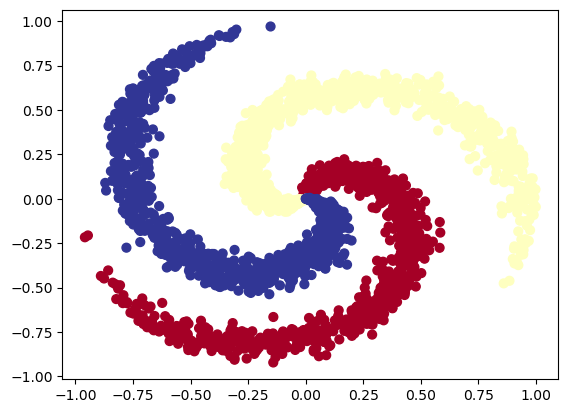

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 56
np.random.seed(RANDOM_SEED)
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

### Data Preprocessing

In [ ]:
X = torch.tensor(X,device=device).float()
y = torch.tensor(y,device=device).long()
print('Shape of X and y',X.shape,y.shape)

X_train_valid, X_test,y_train_valid,y_test = train_test_split(X,y,test_size=0.2)
X_train,X_valid,y_train,y_valid = train_test_split(X_train_valid,y_train_valid,test_size=0.2)

print(X_train.shape,X_valid.shape,X_test.shape)
print(y_train.shape,y_valid.shape,y_test.shape)

Shape of X and y torch.Size([3000, 2]) torch.Size([3000])
torch.Size([1920, 2]) torch.Size([480, 2]) torch.Size([600, 2])
torch.Size([1920]) torch.Size([480]) torch.Size([600])


### Model Setup

In [ ]:
class MultiClassCLF(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )

    def forward(self,x):
        return self.layers(x)

model = MultiClassCLF(2,8,4).to(device)
model

MultiClassCLF(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
EPOCHS = 800
LEARNING_RATE = 0.01
LOG_INTERVAL = 50

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),LEARNING_RATE)

torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=4).to(device)

### Train Valid Loop

In [ ]:
def train_valid_loop(epochs,X_train,X_valid,y_train,y_valid,model,optimizer,loss_function,torchmetrics_accuracy,log_interval):

    for epoch in range(epochs):
        # Train
        model.train()
        y_train_logits = model(X_train)
        loss = loss_function(y_train_logits,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc = torchmetrics_accuracy(y_train_logits,y_train)*100

        # valid
        model.eval()
        with torch.inference_mode():
            y_valid_logits = model(X_valid)
            valid_loss = loss_function(y_valid_logits,y_valid)
            valid_acc = torchmetrics_accuracy(y_valid_logits,y_valid)*100

        # Print
        if epoch % log_interval == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {valid_loss:.4f} | Test Accuracy | {valid_acc:.2f}%")



In [ ]:
train_valid_loop(EPOCHS,X_train,X_valid,y_train,y_valid,model,optimizer,loss_function,torchmetrics_accuracy,LOG_INTERVAL)

Epoch: 0 | Train Loss: 1.2609 | Train Accuracy: 42.29% | Test Loss: 1.2455 | Test Accuracy | 42.92%


Epoch: 50 | Train Loss: 0.7949 | Train Accuracy: 59.01% | Test Loss: 0.7239 | Test Accuracy | 58.75%
Epoch: 100 | Train Loss: 0.6472 | Train Accuracy: 67.86% | Test Loss: 0.5633 | Test Accuracy | 69.58%
Epoch: 150 | Train Loss: 0.4735 | Train Accuracy: 81.04% | Test Loss: 0.3371 | Test Accuracy | 90.83%
Epoch: 200 | Train Loss: 0.3914 | Train Accuracy: 85.00% | Test Loss: 0.2419 | Test Accuracy | 96.04%
Epoch: 250 | Train Loss: 0.3498 | Train Accuracy: 89.01% | Test Loss: 0.1961 | Test Accuracy | 97.71%
Epoch: 300 | Train Loss: 0.3323 | Train Accuracy: 88.33% | Test Loss: 0.1676 | Test Accuracy | 97.08%
Epoch: 350 | Train Loss: 0.3054 | Train Accuracy: 90.36% | Test Loss: 0.1514 | Test Accuracy | 97.92%
Epoch: 400 | Train Loss: 0.2743 | Train Accuracy: 91.30% | Test Loss: 0.1369 | Test Accuracy | 97.50%
Epoch: 450 | Train Loss: 0.2746 | Train Accuracy: 90.99% | Test Loss: 0.1200 | Test Accuracy | 97.71%
Epoch: 500 | Train Loss: 0.2480 | Train Accuracy: 91.41% | Test Loss: 0.1081 | Test

### Model Inference on Test set

In [ ]:
# Inference on Test
model.eval()
with torch.inference_mode():
    y_test_logits = model(X_test)
    test_loss = loss_function(y_test_logits,y_test)
    test_acc = torchmetrics_accuracy(y_test_logits,y_test)*100

In [ ]:
test_acc,test_loss

(tensor(99.6667, device='cuda:0'), tensor(0.0565, device='cuda:0'))

In [ ]:
X_train.shape

torch.Size([1920, 2])

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MultiClassCLF                            --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       24
│    └─Dropout: 2-2                      --
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       72
│    └─Dropout: 2-5                      --
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       36
Total params: 132
Trainable params: 132
Non-trainable params: 0

# Datasets and Data Loader

### Data Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

from torchinfo import summary

import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

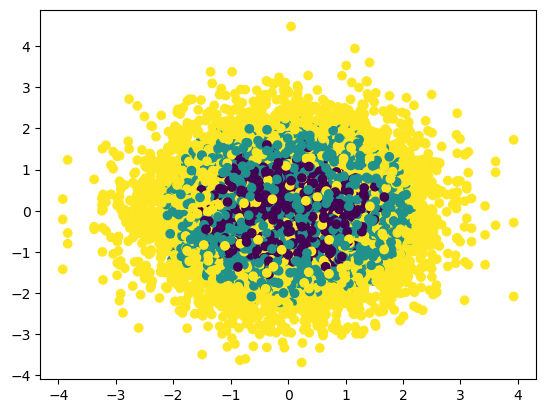

In [ ]:
X,y = make_gaussian_quantiles(n_classes=3,n_samples=5000,n_features=5,random_state=42,shuffle=True)
plt.scatter(
    X[:,0],
    X[:,3],
    c=y
)
plt.scatter(
    X[:,0],
    X[:,1],
    c=y
)
plt.scatter(
    X[:,0],
    X[:,2],
    c=y
)

In [ ]:
X =  torch.tensor(X,device=device).float()
y = torch.tensor(y,device=device).long()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5555)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4000, 5]),
 torch.Size([1000, 5]),
 torch.Size([4000]),
 torch.Size([1000]))

In [ ]:
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=True
)

### Model

In [ ]:
class GausianCLF(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Linear(5,16),
            nn.GELU(),
            nn.Dropout(0.1),
        )
        self.block2 = nn.Sequential(
            nn.Linear(16,128),
            nn.GELU(),
            nn.Dropout(0.1),
        )
        self.block3 = nn.Sequential(
            nn.Linear(128,3),
        )


    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

model = GausianCLF().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
GausianCLF                               --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       96
│    └─GELU: 2-2                         --
│    └─Dropout: 2-3                      --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       2,176
│    └─GELU: 2-5                         --
│    └─Dropout: 2-6                      --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       387
Total params: 2,659
Trainable params: 2,659
Non-trainable params: 0

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          log_interval: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      if epoch % log_interval == 0:
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

### Training

In [ ]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
LOG_INTERVAL = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)

logs=train(  model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        loss_fn=loss_function,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        log_interval=LOG_INTERVAL,
        device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0541 | train_acc: 0.5107 | test_loss: 1.0123 | test_acc: 0.5546
Epoch: 11 | train_loss: 0.4137 | train_acc: 0.8435 | test_loss: 0.3126 | test_acc: 0.9206
Epoch: 21 | train_loss: 0.3640 | train_acc: 0.8557 | test_loss: 0.2433 | test_acc: 0.9368
Epoch: 31 | train_loss: 0.3427 | train_acc: 0.8696 | test_loss: 0.2289 | test_acc: 0.9399
Epoch: 41 | train_loss: 0.3280 | train_acc: 0.8748 | test_loss: 0.2146 | test_acc: 0.9420
Epoch: 51 | train_loss: 0.3191 | train_acc: 0.8752 | test_loss: 0.2213 | test_acc: 0.9331
Epoch: 61 | train_loss: 0.2832 | train_acc: 0.8992 | test_loss: 0.2106 | test_acc: 0.9404
Epoch: 71 | train_loss: 0.2793 | train_acc: 0.8950 | test_loss: 0.2023 | test_acc: 0.9310
Epoch: 81 | train_loss: 0.2698 | train_acc: 0.9041 | test_loss: 0.1988 | test_acc: 0.9289
Epoch: 91 | train_loss: 0.2486 | train_acc: 0.9102 | test_loss: 0.1908 | test_acc: 0.9266


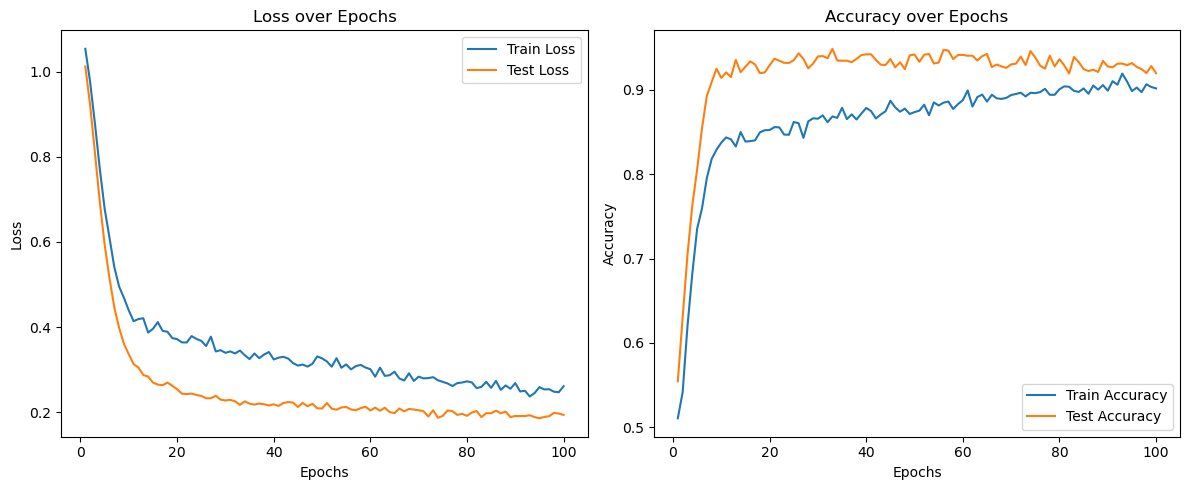

In [ ]:
epochs = range(1, len(logs['train_loss']) + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, logs['train_loss'], label='Train Loss')
plt.plot(epochs, logs['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, logs['train_acc'], label='Train Accuracy')
plt.plot(epochs, logs['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# RNN

In [ ]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader

from torchinfo import summary
from torchmetrics import Accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
X_text,y = fetch_20newsgroups(
    categories = ["alt.atheism","talk.religion.misc","comp.graphics","sci.space",],
    return_X_y=True
)

len(X),len(y)

(2034, 2034)

In [ ]:
# # Sample sentences
# X = [
#     "I love this product",
#     "This is the best day of my life",
#     "I am so happy",
#     "I hate this",
#     "This is the worst experience ever",
#     "I am so sad"
# ]

# # Labels: 1 for positive, 0 for negative
# y = np.array([1, 1, 1, 0, 0, 0])

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_text).toarray()

X = torch.tensor(X,device=device).float()
y = torch.tensor(y,device=device).long()

X.shape,X.dtype,y.shape,y.dtype

(torch.Size([2034, 34118]), torch.float32, torch.Size([2034]), torch.int64)

In [ ]:
y.unique(return_counts=True)

(tensor([0, 1, 2, 3], device='cuda:0'),
 tensor([480, 584, 593, 377], device='cuda:0'))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([1627, 34118]),
 torch.Size([407, 34118]),
 torch.Size([1627]),
 torch.Size([407]))

In [ ]:
# Corrected model definition
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x has shape (batch_size, input_size)
        x = x.unsqueeze(1)  # Add a sequence length dimension, making it (batch_size, 1, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size, device=x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Get the last time step's output
        return out

# Ensure input_size matches the number of features (columns) in X_train
input_size = X_train.size(1)  # This is the number of features from CountVectorizer

model = RNNClassifier(
    input_size=input_size,
    hidden_size=1024,
    output_size=4  # Assuming binary classification
).to(device)


In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
RNNClassifier                            --
├─RNN: 1-1                               35,987,456
├─Linear: 1-2                            4,100
Total params: 35,991,556
Trainable params: 35,991,556
Non-trainable params: 0

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),LEARNING_RATE)

torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=4).to(device)

In [ ]:
def main(epochs,model,optimizer,loss_function,log_interval,X_train,X_test,y_train,y_test):

    for epoch in range(epochs):
        # Training
        model.train()
        y_logits = model(X_train)
        loss = loss_function(y_logits,y_train)
        optimizer.zero_grad()
        loss.backward()
        train_acc = torchmetrics_accuracy(y_logits,y_train)*100.

        # Inference
        model.eval()
        with torch.inference_mode():
            y_test_logits = model(X_test)
            test_loss = loss_function(y_test_logits,y_test)
            test_acc = torchmetrics_accuracy(y_test_logits,y_test)*100.

        # Print
        if epoch % log_interval == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy | {test_acc:.2f}%")



In [ ]:
EPOCHS = 1000
LOG_INTERVAL = 100
LEARNING_RATE = 0.1

main(EPOCHS,model,optimizer,loss_function,LOG_INTERVAL,X_train,X_test,y_train,y_test)

Epoch: 0 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 100 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 200 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 300 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 400 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 500 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 600 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 700 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 800 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test Accuracy | 25.80%
Epoch: 900 | Train Loss: 1.4471 | Train Accuracy: 26.37% | Test Loss: 1.4542 | Test 

In [ ]:
import gc

model
del model


NameError: name 'model' is not defined

In [ ]:
gc.collect()
torch.cuda.empty_cache()